# Tutorial 8: Recurrent Neural Networks (RNN)

## Objectives

After this tutorial you will be able to:
- Understand how RNNs differ from traditional feedforward neural networks by processing sequential data and capturing temporal dependencies.
- Distinguish between vanilla RNNs and LSTMs, understanding the limitations of vanilla RNNs with vanishing/exploding gradients and how LSTMs address this issue.
- Utilize RNNs to analyze historical process data and sensor readings to identify patterns that can be leveraged for process optimization and control.

<h2>Table of Contents</h2>

<ol>
    <li>
        <a href="#1">Recurrent Neural Networks (RNN)</a>
    </li>
    <br>
</ol>


<hr id="1">
<h2>1. Recurrent Neural Networks (RNN)</h2>


### Overview

Recurrent Neural Networks (RNNs) are a powerful class of neural networks designed to handle **sequential data**. Unlike traditional feedforward neural networks that process each data point independently, RNNs can capture **temporal dependencies** within the data sequence. This makes them well-suited for tasks like:

* **Natural Language Processing (NLP):**  Language translation, text generation, sentiment analysis
* **Speech Recognition:**  Transcribing spoken language into text
* **Time Series Forecasting:**  Predicting future stock prices, weather patterns, sensor readings
* **Video Analysis:**  Object tracking, action recognition in videos

### Architecture

An RNN is similar to a feedforward neural network but with a key difference: it has a **feedback loop**. 

1. **Hidden Layer:**  An RNN has a hidden layer that stores information about the **previous input(s)**. This hidden state is updated with each new input, allowing the network to learn how past elements in the sequence influence the current element.
2. **Unfolding:** RNNs can be visualized as "unfolded" versions of a single loop, highlighting how hidden state information is propagated across the sequence.

<div style="text-align: center; margin: auto; margin-top:2rem; width:80%">
    <img src="rnn.jpg" width="100%">
    <br>
    <small></small>
</div>

**Types of RNNs:**

* **Vanilla RNNs:**  The most basic type of RNN, but they can suffer from vanishing or exploding gradients, limiting their ability to learn long-term dependencies.
* **Long Short-Term Memory (LSTM) Networks:** A more complex RNN architecture specifically designed to address the vanishing/exploding gradient problem. LSTMs are widely used for tasks requiring learning long-term dependencies.

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### LSTMs (Long Short-Term Memory)

LSTMs are a specific type of RNN architecture designed to overcome the limitations of vanilla RNNs. They introduce **gates** that control the flow of information through the network:

* **Forget Gate:** Decides what information to forget from the previous hidden state.
* **Input Gate:** Decides what new information to store in the current hidden state.
* **Output Gate:** Decides what information from the current hidden state to output.

These gates allow LSTMs to effectively learn long-term dependencies within sequential data.

<div style="text-align: center; margin: auto; margin-top:2rem; width:80%">
    <img src="lstm.jpg" width="100%">
    <br>
    <small></small>
</div>

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Advantages of RNNs

* **Sequential Data Processing:**  RNNs excel at tasks involving sequential data by capturing temporal relationships.
* **Flexibility:**  RNNs can handle sequences of varying lengths, unlike fixed-size input models.
* **State Representation:**  RNNs can learn internal representations of the data sequence, capturing relevant context.

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Disadvantages of RNNs

* **Vanishing/Exploding Gradients:**  Vanilla RNNs can suffer from vanishing or exploding gradients, limiting their ability to learn long-term dependencies. (LSTMs address this issue.)
* **Computational Cost:**  Training RNNs can be computationally expensive compared to simpler models

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### **Example:** System Identification of a SISO Heater System using RNNs

**Problem Overview:**

This task involves building a mathematical model to predict the temperature of a single input single output (SISO) heater system. The model will be used to estimate future temperature values based on historical and current data on heater power output and system temperature. This problem falls under the umbrella of **System Identification (SI)**, where the goal is to create models of dynamical processes using input-output data.

**Objectives:**

* Develop a recurrent neural network (RNN) model that can accurately predict the next temperature value in the SISO heater system.
* The model should learn the dynamic relationship between heater power output (input) and system temperature (output) over time.
* The model should be able to generalize its learned patterns to predict future temperatures based on unseen data within the same operating range.

**Data:**

* **Type:** Time series data
* **Features:**
    * Input: Heater power output (potentially numerical values)
    * Output: System temperature (potentially numerical values)
* **Training Data:** 4 hours of data sampled every second
* **Test Data:** 14 minutes of data sampled every second (separate from training data)


In [22]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as data

#### Load data

In [23]:
df_train = pd.read_csv('TCLab_train_data.txt')
X_train = df_train[['T1', 'Q1']].values
y_train = df_train[['T1']].values

print(df_train.shape)
df_train.head()

(14400, 5)


,Time,Q1,Q2,T1,T2
0,0.000000,0,0,24.44,0
1,1.000385,0,0,24.44,0
2,2.000896,0,0,24.44,0
3,3.002267,0,0,24.44,0
4,4.002946,0,0,24.44,0


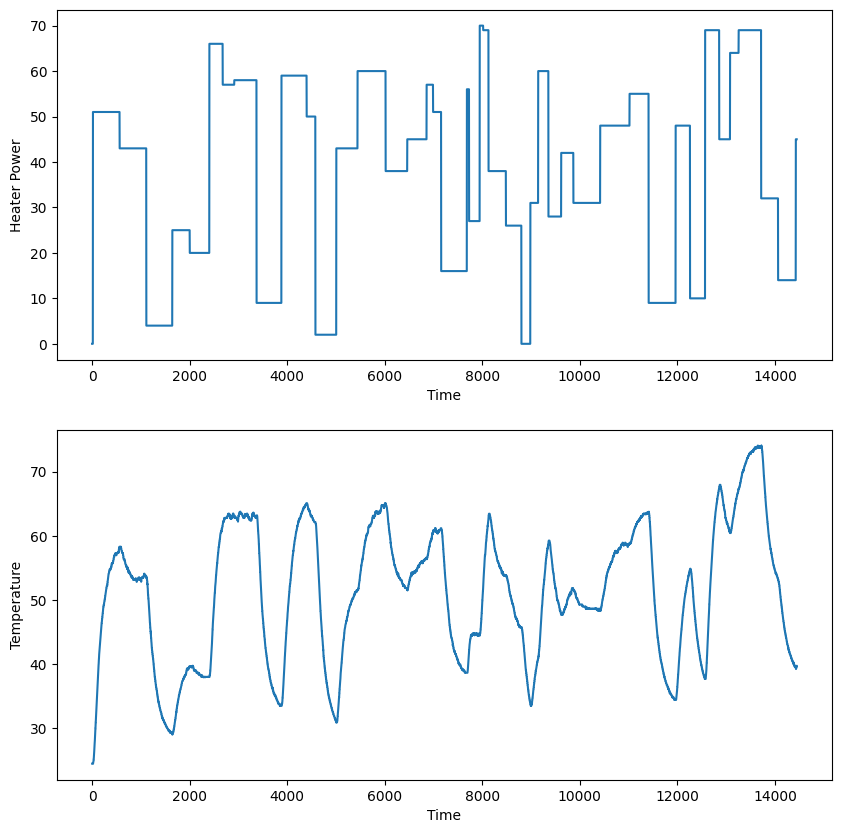

In [24]:
# plot heater and temperature data
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_train['Time'], df_train['Q1'], label='Heater')
plt.xlabel('Time')
plt.ylabel('Heater Power')

plt.subplot(2, 1, 2)
plt.plot(df_train['Time'], df_train['T1'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.show()

In [25]:
# load test data
df_test = pd.read_csv('TCLab_test_data.txt')
X_test = df_test[['T1', 'Q1']].values
y_test = df_test[['T1']].values

print(df_test.shape)
df_test.head()

(841, 5)


,Time,Q1,Q2,T1,T2
0,0.0,0.0,0.0,16.06,16.06
1,1.0,0.0,0.0,16.06,16.06
2,2.0,0.0,0.0,16.06,16.06
3,3.0,0.0,0.0,16.06,16.06
4,4.0,0.0,0.0,16.06,16.06


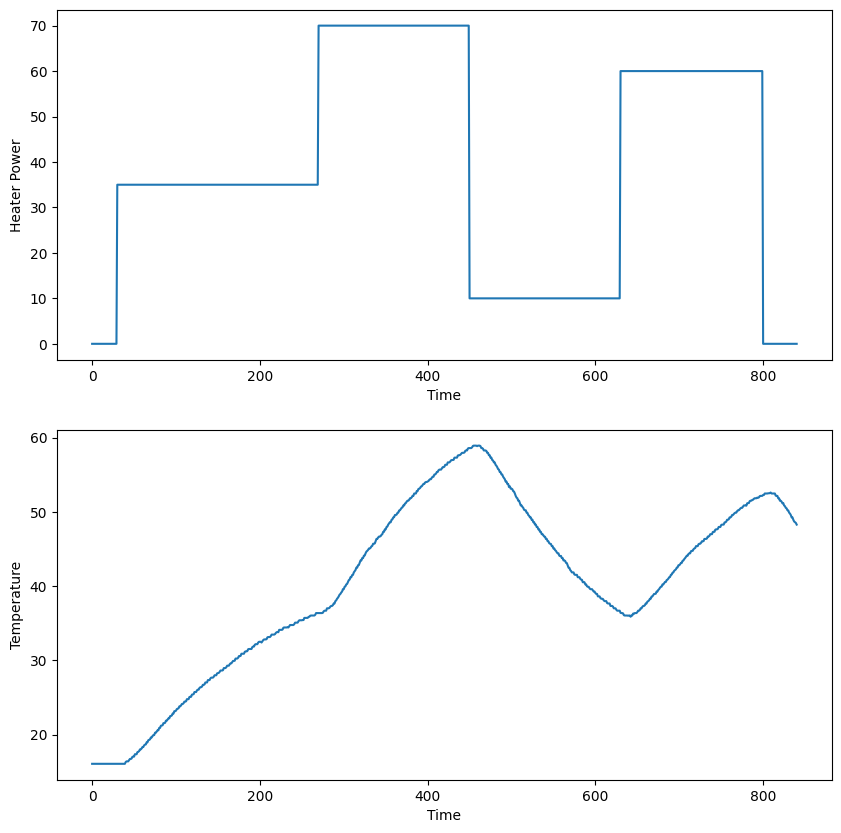

In [26]:
# plot heater and temperature data
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_test['Time'], df_test['Q1'], label='Heater')
plt.xlabel('Time')
plt.ylabel('Heater Power')

plt.subplot(2, 1, 2)
plt.plot(df_test['Time'], df_test['T1'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.show()

create a helper function to create sequential datasets

In [27]:
def create_seq_data(X, y, seq_length):
    # initialize empty x and y
    x_seq = []
    y_seq = []

    # loop through data
    for i in range(len(X) - seq_length):
        x_seq.append(X[i:i+seq_length, :])
        y_seq.append(y[i+seq_length])

    # convert to numpy arrays and return x & y
    return np.array(x_seq), np.array(y_seq)

preprocess the data and create sequential datasets

In [28]:
from sklearn.preprocessing import StandardScaler

# train data
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_train)

# test data
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# create sequences
seq_length = 10
X_seq, y_seq = create_seq_data(X_scaled, y_scaled, seq_length)
X_test_seq, y_test_seq = create_seq_data(X_test_scaled, y_test_scaled, seq_length)

# convert to tensors
X_seq = torch.from_numpy(X_seq).float()
y_seq = torch.from_numpy(y_seq).float()
X_test_seq = torch.from_numpy(X_test_seq).float()
y_test_seq = torch.from_numpy(y_test_seq).float()

# print shapes
print('Training data shape:', X_seq.shape, y_seq.shape)
print('Testing data shape:', X_test_seq.shape, y_test_seq.shape)

Training data shape: torch.Size([14390, 10, 2]) torch.Size([14390, 1])
Testing data shape: torch.Size([831, 10, 2]) torch.Size([831, 1])


#### Build the LSTM model using PyTorch

In [29]:
# build LSTM model using PyTorch
class LSTM(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        # initialize the super/parent class (nn.Module)
        super().__init__()

        # create hidden layer
        self.lstm1 = nn.LSTM(input_size=n_input, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.nn_end = nn.Linear(n_hidden, n_output)


    # define the forward pass of the network
    def forward(self, x):
        x, _ = self.lstm1(x)    # the output of LSTM is a tuple, where the first element is the output of the last hidden layer and the second element is the hidden state of the last hidden layer
        x = x[:, -1, :]         # get the output of the last hidden layer of the last time step
        y = self.nn_end(x)
        return y


    # define the fit method
    def fit(self, X_train, y_train, X_test, y_test, n_epochs, lr=0.001):
        # define loss function and optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # create data loaders
        train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

        # train the model
        for epoch in range(n_epochs):
            # set the model to training mode
            self.train()

            # train the model
            for x, y in train_loader:
                # 1. reset the gradients to zero
                optimizer.zero_grad()

                # 2. compute the output (prediction)
                y_pred = self.forward(x)

                # 3. compute the loss
                loss = criterion(y_pred, y)

                # 4. backpropagation
                loss.backward()

                # 5. update the model parameters
                optimizer.step()

            # evaluate the model
            if (epoch+1) % 10 == 0 or epoch == 0:
                # set the model to evaluation mode
                self.eval()
                with torch.no_grad():
                    # calculate the loss
                    y_train_pred = self.forward(X_train)
                    train_loss = criterion(y_train_pred, y_train)
                    y_test_pred = self.forward(X_test)
                    test_loss = criterion(y_test_pred, y_test)

                    # print the loss
                    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')


    # define the predict method
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            pred = self.forward(X)

        return pred

# initialize the model
model = LSTM(n_input=2, n_hidden=25, n_output=1)

Train the model

Epoch: 1, Train Loss: 0.00047208310570567846, Test Loss: 0.003888420294970274


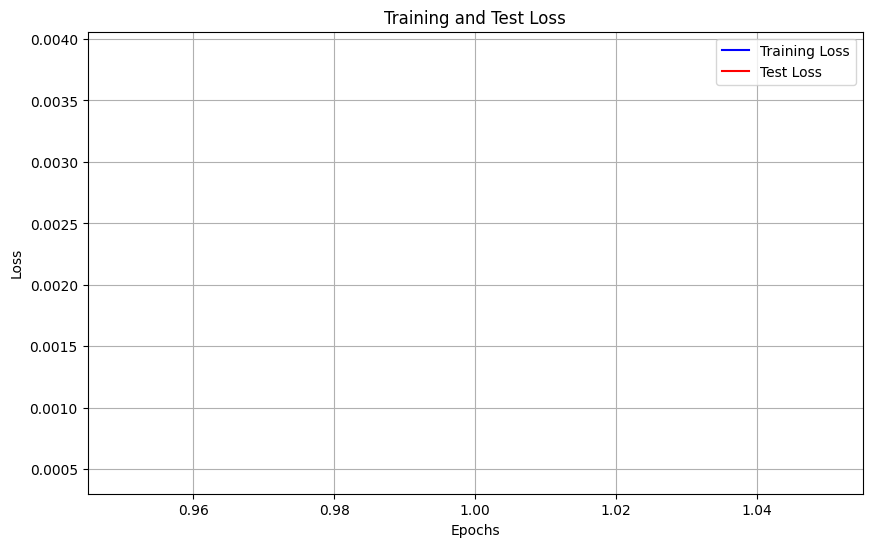

Epoch: 10, Train Loss: 7.60524781071581e-05, Test Loss: 0.0033753877505660057


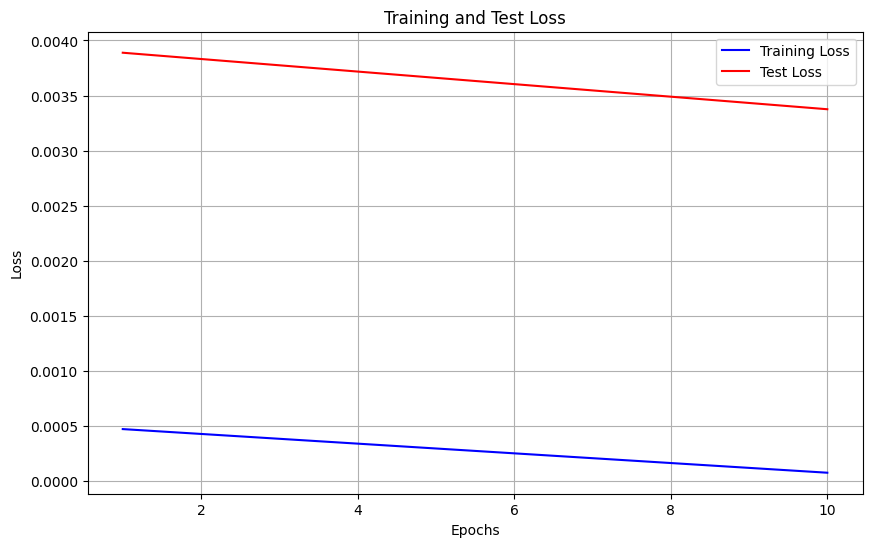

Epoch: 20, Train Loss: 7.644479774171486e-05, Test Loss: 0.0011304409708827734


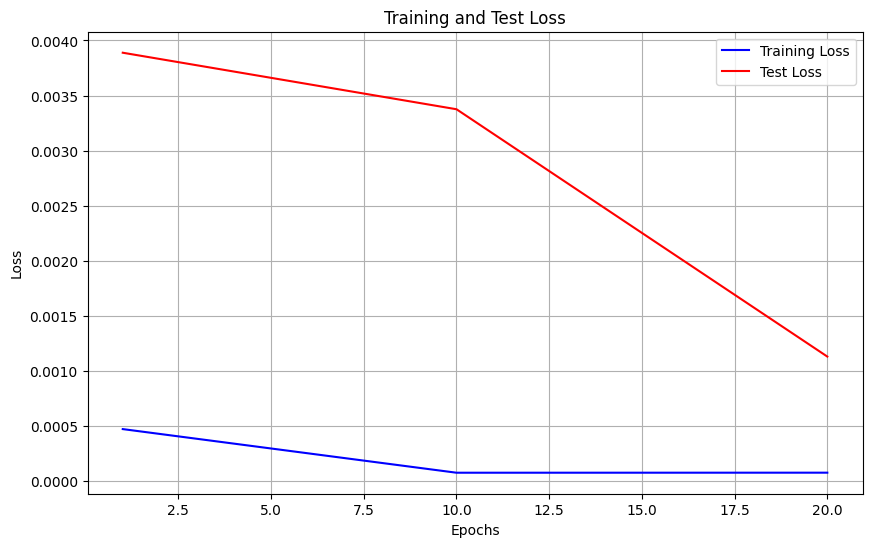

Epoch: 30, Train Loss: 4.325877671362832e-05, Test Loss: 0.004838762804865837


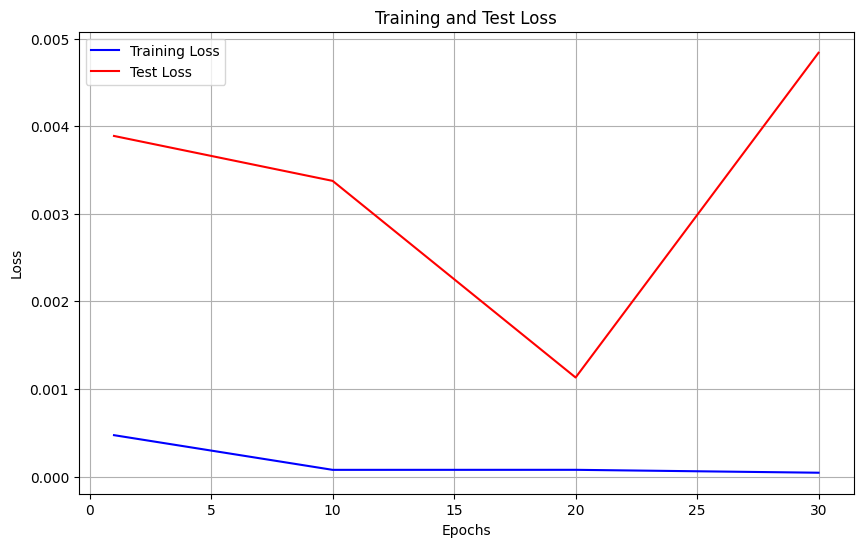

Epoch: 40, Train Loss: 4.211588384350762e-05, Test Loss: 0.006976535078138113


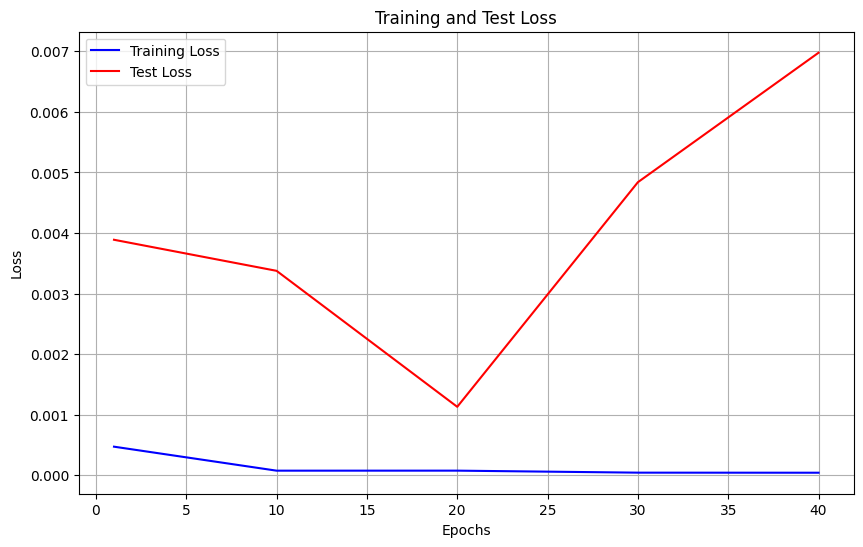

Epoch: 50, Train Loss: 3.878235293086618e-05, Test Loss: 0.002570618176832795


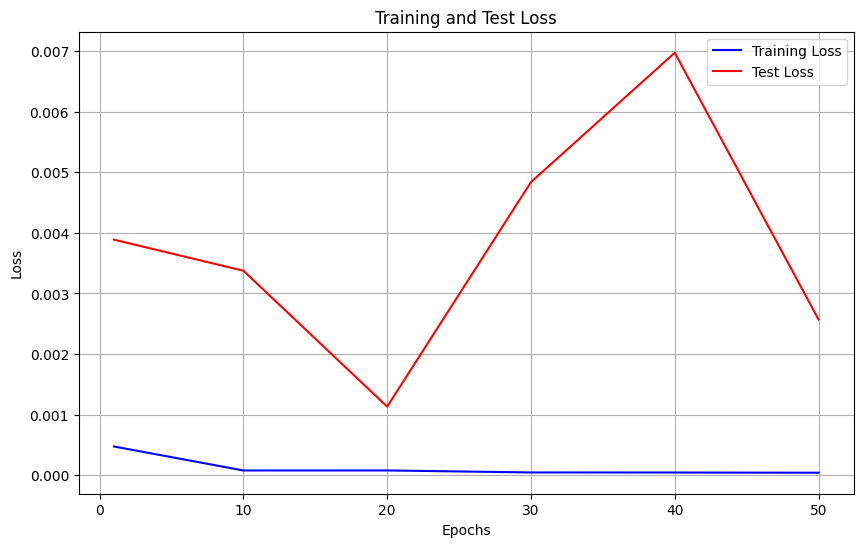

In [30]:
# train the model
model.fit(X_seq, y_seq, X_test_seq, y_test_seq, n_epochs=50, lr=0.01)

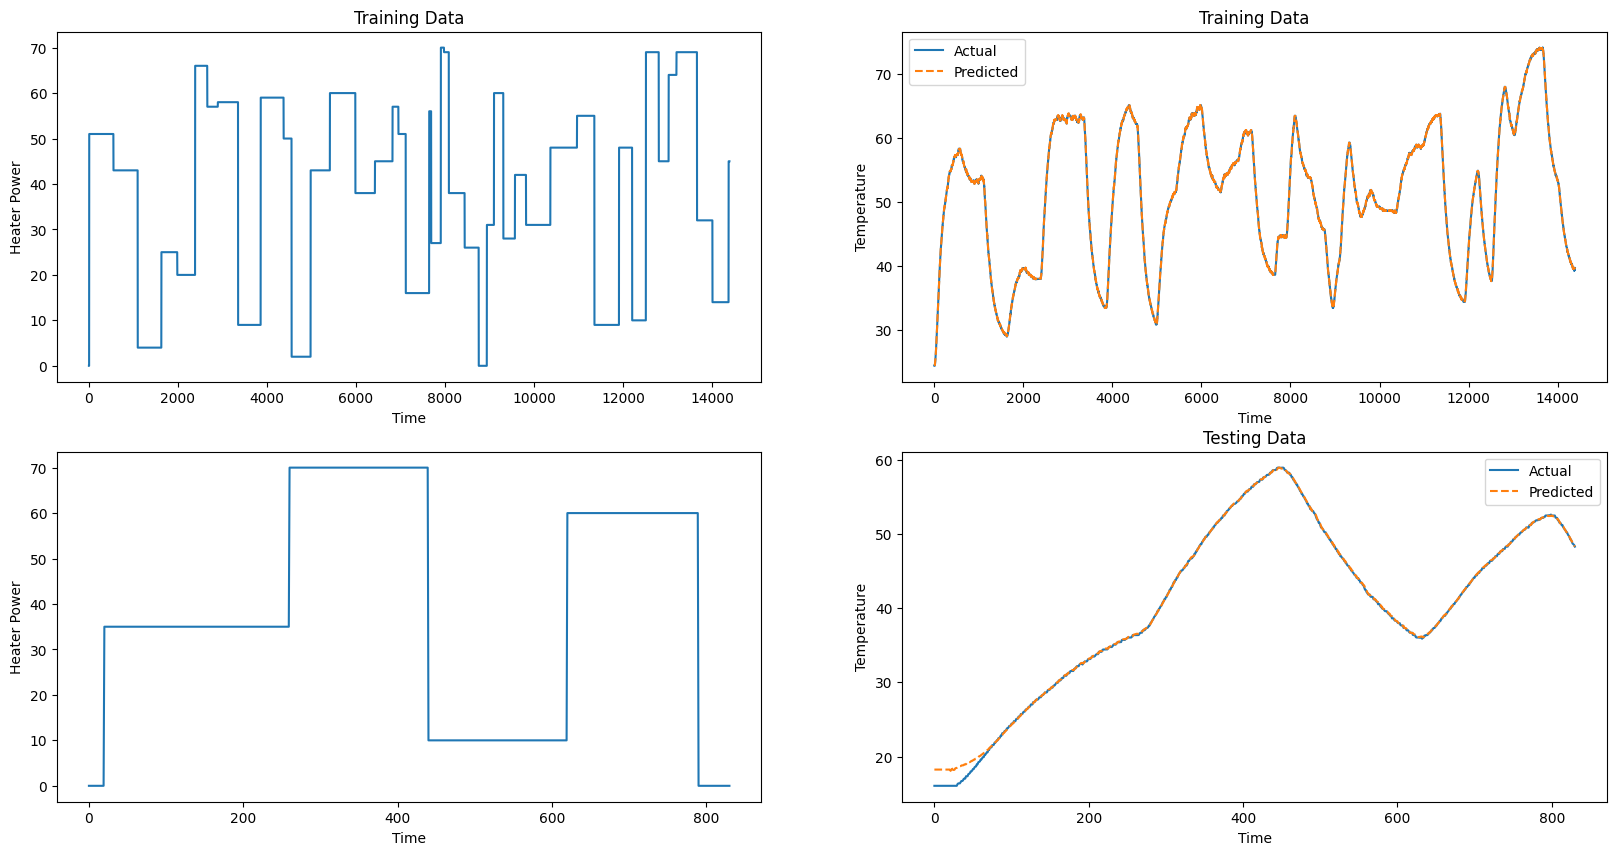

In [31]:
# make predictions
y_train_pred = model.predict(X_seq)
y_test_pred = model.predict(X_test_seq)

# inverse transform the predictions
y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)

# plot the predictions vs actual
plt.figure(figsize=(20, 10))

# training
plt.subplot(2, 2, 1)
plt.plot(X_train[seq_length:, 1])
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Heater Power')

plt.subplot(2, 2, 2)
plt.plot(y_train[seq_length:], label='Actual')
plt.plot(y_train_pred, label='Predicted', linestyle='--')
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

# testing
plt.subplot(2, 2, 3)
plt.plot(X_test[seq_length:, 1])
plt.xlabel('Time')
plt.ylabel('Heater Power')

plt.subplot(2, 2, 4)
plt.plot(y_test[seq_length:], label='Actual')
plt.plot(y_test_pred, label='Predicted', linestyle='--')
plt.title('Testing Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

plt.show()

<hr style="margin-top: 4rem;">
<h2>Author</h2>

<a href="https://github.com/SamerHany">Samer Hany</a>

<h2>References</h2>

- Ankur Kumar, Jesus Flores-Cerrillo, 2022. Machine Learning in Python for Process Systems Engineering
- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An introduction to statistical learning with applications in Python. Springer Texts in Statistics